In [25]:
# Loading Packages
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta

from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import distance

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures


from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import pickle
from utils import *

%load_ext autoreload
%autoreload 2

sns.set(style='white', context='notebook', palette='deep')
pd.set_option('display.max_columns', 360)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# load our train set of data
train = pd.read_csv('kc_house_data_train.csv')

# seperate Target variable 
target = train['price']

In [48]:
# Getting rid of higly correlated features

train.drop(columns = ['sqft_above', 'sqft_living15', 'sqft_lot15','id','Unnamed: 0','price'], inplace=True)

In [49]:
# define catgorical and continius variables

categorical_variables = ['condition', 'view', 'floors', 'grade',  'waterfront', 'zipcode']
contin_variables = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_basement']

In [50]:
# Cleaning data wit map_bed_bath function

train = train.apply(map_bed_bath, axis = 1)

# Lets Create new feature - distance from the house to downtown in miles by using function distance_to_dwntwn
train['dist_dntwn'] = train.apply(distance_to_dwntwn, axis = 1)  
train = train.drop(columns = ['lat','long'])

In [51]:
# Createing catigorical variable based on sqft_basement variable
train['basement'] = train['sqft_basement'].map(lambda x : 1 if x != 0 else 0)

# Add it to our list of categorical variables
categorical_variables = categorical_variables+['basement']

# Generate dummies based on categorica variables with function to_dummies
train = to_dummies(train,categorical_variables)

In [52]:
# Creating new features based on when the house was built and when it was renovated.

train['years_old'] = train['yr_built'].map(lambda x : 2021-x)
train['abs_years_old'] = train['years_old'].map(lambda x: abs(x-round(train['years_old'].mean())))

# Converting 'yr_renovated' column to datetime format with function format_yr_renov
# And Create new features 'yrs_from_renov' based on 'yr_renovated'

train = train.apply(format_yr_renov, axis=1)
train['yrs_from_renov'] = train['yr_renovated'].map(lambda x : relativedelta(datetime.datetime.now(), x).years)

In [53]:
# Drop some columns that we wont use anymore
train = train.drop(columns=['date','yr_built','yr_renovated'])

In [54]:
# Lets create poly features degrtee 2 for quantitative variables except features with dummies

fts_for_poly = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_basement', 'dist_dntwn', 'years_old', 'yrs_from_renov', 'abs_years_old']

# generate poly features degree 2 with function create_poly_df
df_poly2 = create_poly_df(train[fts_for_poly], 2)

# Seperate features with dummies values 
not_poly_fts = [x for x in train.columns if x not in fts_for_poly]

# Combine poly 2 degree variables and dummies 
train_poly2 = pd.merge(df_poly2, train[not_poly_fts], left_index=True, right_index=True).drop(columns='gra_3')

In [55]:
# Evaluating model with function train_test_valid
train_test_valid(train_poly2,target)

Training: RMSE 133434 vs. Testing: RMSE 127371
Perfomance : 5 %


In [58]:
# We not overfitting our model as RMSE on test set 5% lower then RMSE on train set

In [59]:
# Lets create poly features 3rd degree and Evaluate model with function train_test_valid

df_poly3 = create_poly_df(train[fts_for_poly], 3)
not_poly_fts = [x for x in train.columns if x not in fts_for_poly]
train_poly3 = pd.merge(df_poly3, train[not_poly_fts], left_index=True, right_index=True)
train_test_valid(train_poly3, target)

Training: RMSE 183497 vs. Testing: RMSE 194217
Perfomance : 6 %


In [60]:
# Lets create poly features 4rd degree and Evaluate model with function train_test_valid

df_poly4 = create_poly_df(train[fts_for_poly], 4)
not_poly_fts = [x for x in train.columns if x not in fts_for_poly]
train_poly4 = pd.merge(df_poly4, train[not_poly_fts], left_index=True, right_index=True)
train_test_valid(train_poly4, target)

Training: RMSE 188479 vs. Testing: RMSE 1561972
Perfomance : 729 %


Training: RMSE 133434 vs. Testing: RMSE 127370
Perfomance : 5 %


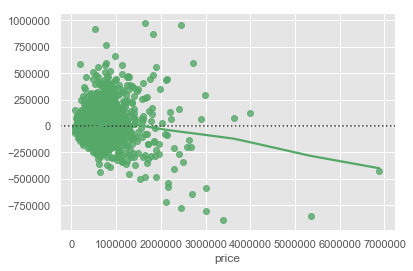

In [61]:
# Let's scale our features and eavluate model with function scale_transform_validate 
# Scaling doesn't make model better or more eficient! It is only scale features (X_train, X_test sets)

scale_transform_validate(train_poly2,target,residuals=True)

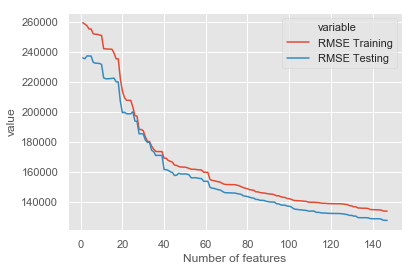

In [62]:
# Lets run feature selection function for our poly featers degree 2
# And see perfomance of RMSE on Training and Test set based on number of features

f_test_select_vis(train_poly2, target)

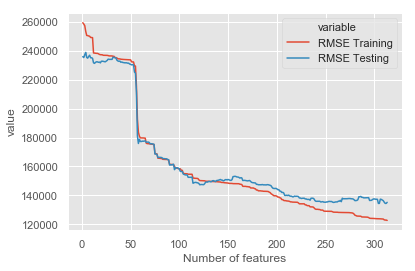

In [63]:
# Lets run feature selection function for our poly featers degree 3
# And see perfomance of RMSE on Training and Test set based on number of features

f_test_select_vis(train_poly3, target)

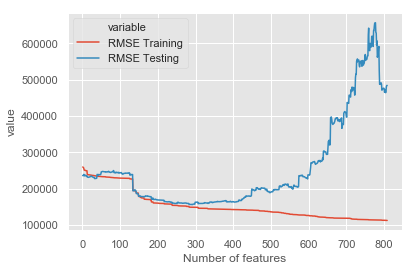

In [64]:
# Lets run feature selection function for our poly featers degree 4
# And see perfomance of RMSE on Training and Test set based on number of features

f_test_select_vis(train_poly4, target)

In [65]:
# As we can see All features in training set are important in order to achive the lowest RMSE
# on Training set without significant overfitting on Test 

In [66]:
# Refitting  model to the entire dataset
# Saving final model using pickle scale_fit_pickle_origin function

In [67]:
model = scale_fit_pickle_origin(train_poly2, target)

 CONGRATS !!! You sucessfuly created you pickles for SCALER and MODEL
